In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

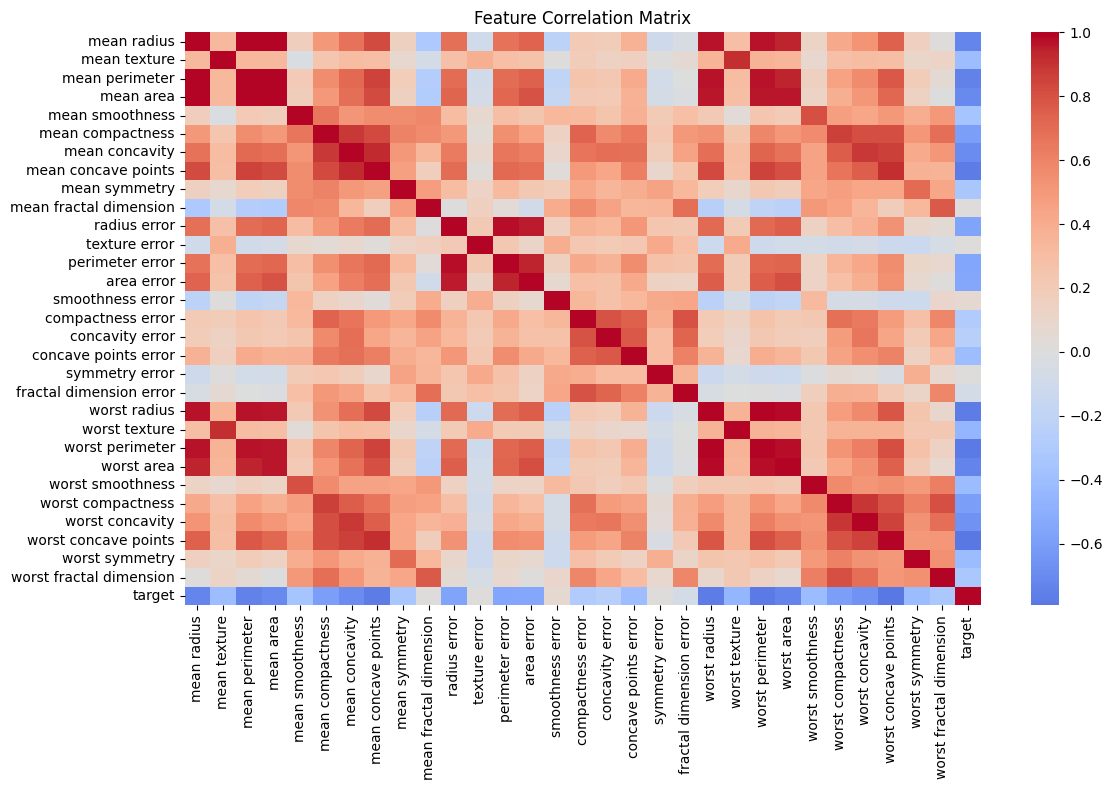

Features to remove: ['mean perimeter', 'mean area', 'mean concave points', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst concave points']
Number of features to remove: 10


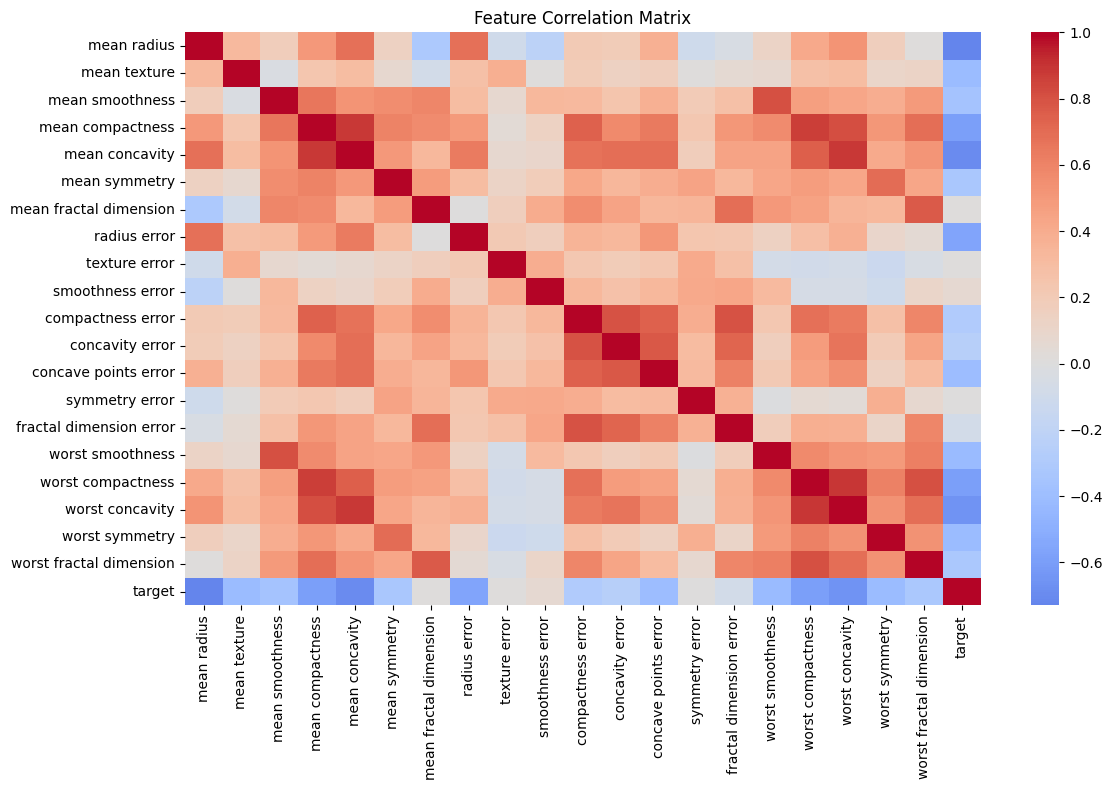

target
1    0.627417
0    0.372583
Name: proportion, dtype: float64


In [3]:
data = load_breast_cancer()
X = data.data
y = data.target

df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

# EDA
# print('info', df.info())

# print('describe', df.describe())

# missing values
# print('missing values', df.isnull().sum().sum())

# Check correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

corr_matrix = df.corr().abs()
    
# Create upper triangle mask
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
# Find features with correlation above threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(f"Features to remove: {to_drop}")
print(f"Number of features to remove: {len(to_drop)}")

# Remove highly correlated features
df = df.drop(columns=to_drop)

# Check correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()
print(df['target'].value_counts(normalize=True))

In [4]:
def run_logistic_regression(X, y, degree, penalty='l2', C_values=None, n_splits=5):
    # K-Fold Cross Validation
    kf = KFold(n_splits=n_splits)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_scaled)
    
    results = []
    for C in C_values:
        fold_scores = []
        train_scores = []

        for i,(train_index, test_index) in enumerate(kf.split(X_poly)):
            # print(f"Fold {i}:")
            # print(f"  Training dataset index: {train_index}")
            # print(f"  Test dataset index: {test_index}")

            X_train, X_test = X_poly[train_index], X_poly[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = LogisticRegression(penalty=penalty, C=C, max_iter=1000)
            model.fit(X_train, y_train)
        
            train_score = model.score(X_train, y_train)
            test_score = model.score(X_test, y_test)
        
            fold_scores.append(test_score)
            train_scores.append(train_score)
            print(f"Fold {i}: train_score: {train_score}, test_score: {test_score}")
        
        results.append({
            'degree': degree,
            'C': float(C),  
            'train_score': float(np.mean(train_scores)),  
            'test_score': float(np.mean(fold_scores)),
            'val_std': float(np.std(fold_scores)),
            'gap': float(np.mean(train_scores) - np.mean(fold_scores))
        })
    
    return pd.DataFrame(results)

In [5]:
# Run experiments for different polynomial degrees
degrees = [1, 2, 3]
# regularization strength (0.0001, 0.001, 0.01, 0.1, 1, 10, 100) (strong to weak)
C_values = np.logspace(-6, 6, 20)
all_results = []  # Use list instead of DataFrame for concatenation

for degree in degrees:
    results = run_logistic_regression(X, y, degree, C_values=C_values, n_splits=5)
    all_results.append(results)

all_results = pd.concat(all_results, ignore_index=True)

Fold 0: train_score: 0.6835164835164835, test_score: 0.40350877192982454
Fold 1: train_score: 0.6417582417582418, test_score: 0.5701754385964912
Fold 2: train_score: 0.621978021978022, test_score: 0.6491228070175439
Fold 3: train_score: 0.5978021978021978, test_score: 0.7456140350877193
Fold 4: train_score: 0.5921052631578947, test_score: 0.7699115044247787
Fold 0: train_score: 0.6835164835164835, test_score: 0.40350877192982454
Fold 1: train_score: 0.6417582417582418, test_score: 0.5701754385964912
Fold 2: train_score: 0.621978021978022, test_score: 0.6491228070175439
Fold 3: train_score: 0.5978021978021978, test_score: 0.7456140350877193
Fold 4: train_score: 0.5921052631578947, test_score: 0.7699115044247787
Fold 0: train_score: 0.6835164835164835, test_score: 0.40350877192982454
Fold 1: train_score: 0.6417582417582418, test_score: 0.5701754385964912
Fold 2: train_score: 0.621978021978022, test_score: 0.6491228070175439
Fold 3: train_score: 0.5978021978021978, test_score: 0.745614035

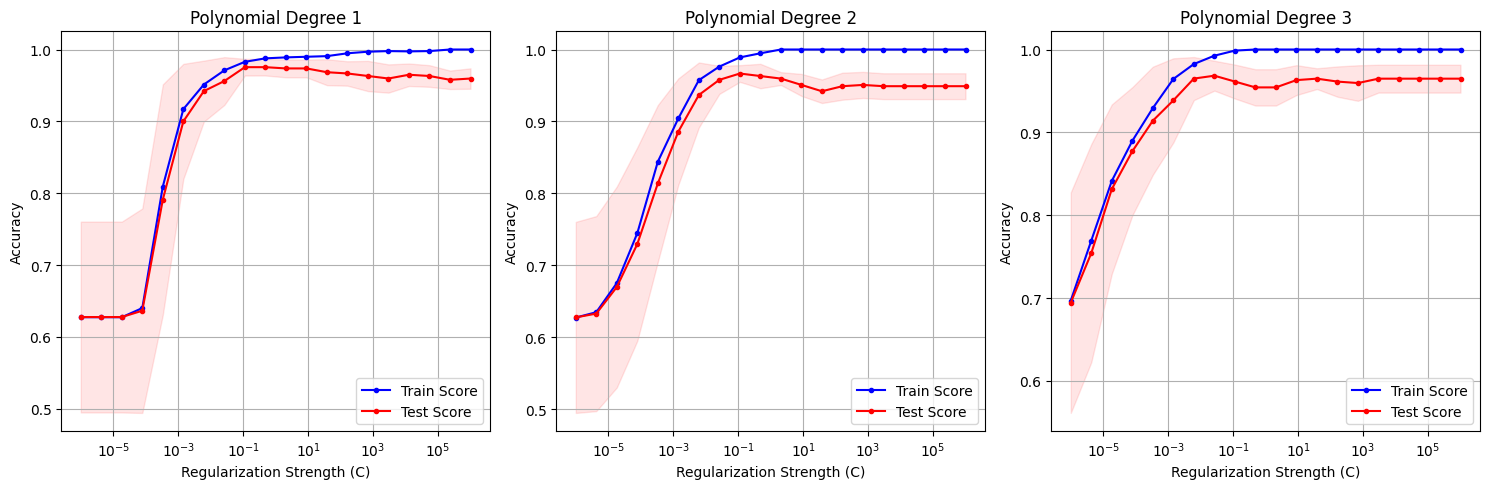

In [6]:
# Plot results
plt.figure(figsize=(15, 5))
for i, degree in enumerate(degrees, 1):
    plt.subplot(1, 3, i)
    degree_results = all_results[all_results['degree'] == degree]
    
    # Plot training score
    plt.semilogx(degree_results['C'], degree_results['train_score'], 
                 'b.-', label='Train Score')
    
    # Plot validation score with error bands
    plt.semilogx(degree_results['C'], degree_results['test_score'], 
                 'r.-', label='Test Score')
    plt.fill_between(degree_results['C'],
                    degree_results['test_score'] - degree_results['val_std'],
                    degree_results['test_score'] + degree_results['val_std'],
                    color='r', alpha=0.1)
    
    plt.xlabel('Regularization Strength (C)')
    plt.ylabel('Accuracy')
    plt.title(f'Polynomial Degree {degree}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show() 

In [8]:
# Print best results
print("\nBest Results for Each Polynomial Degree:")
for degree in degrees:
    degree_results = all_results[all_results['degree'] == degree]
    best_result = degree_results.loc[degree_results['test_score'].idxmax()]
    
    print(f"\nDegree {degree}:")
    print(f"Best C: {best_result['C']:.6f}")
    print(f"Training accuracy: {best_result['train_score']:.4f}")
    print(f"Validation accuracy: {best_result['test_score']:.4f} ± {best_result['val_std']:.4f}")
    print(f"Gap (train-val): {best_result['gap']:.4f}")


Best Results for Each Polynomial Degree:

Degree 1:
Best C: 0.483293
Training accuracy: 0.9877
Validation accuracy: 0.9754 ± 0.0116
Gap (train-val): 0.0123

Degree 2:
Best C: 0.112884
Training accuracy: 0.9890
Validation accuracy: 0.9666 ± 0.0116
Gap (train-val): 0.0224

Degree 3:
Best C: 0.026367
Training accuracy: 0.9925
Validation accuracy: 0.9684 ± 0.0180
Gap (train-val): 0.0241
